In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

from torchvision import transforms

%matplotlib inline

In [2]:
env = gym.make("Pong-v0")

In [3]:
downsample = 4

def preprocess(frame):
    '''from karpathy.'''
    I = frame
    I = I[35:195] # crop
    I = I[::downsample,::downsample,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    tensor = torch.from_numpy(I).float()
    return tensor.unsqueeze(0).unsqueeze(0) #BCHW

def clip_grads(net, low=-10, high=10):
    """Gradient clipping to the range [low, high]."""
    parameters = [param for param in net.parameters()
                  if param.grad is not None]
    for p in parameters:
        p.grad.data.clamp_(low, high)
        
if torch.cuda.is_available():
    def to_var(x, requires_grad=False, gpu=None):
        x = x.cuda(gpu)
        return Variable(x, requires_grad=requires_grad)
else:
    def to_var(x, requires_grad=False, vgpu=None):
        return Variable(x, requires_grad=requires_grad)

In [4]:
class Net(nn.Module):
    def __init__(self, action_n):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1,32,kernel_size=5),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                                  nn.Conv2d(32,128,kernel_size=5),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                                  nn.Conv2d(128,32,kernel_size=5),nn.ReLU(),nn.AdaptiveMaxPool2d(output_size=1))
        self.fc = nn.Linear(32, action_n)
        
    def forward(self, x):
        feat = self.conv(x)
        logit = self.fc(feat.view(feat.size(0),-1))
        return logit

In [5]:
class PolicyGradient:
    
    def __init__(self, model, gamma=0.99, eps=1.e-6, running_gamma=0.99, running_start=0,
#                 episode2thresh=lambda i: 0.05+0.9*np.exp(-1. * i / 100) if i>150 else 0): # eploration will start after 150 episodes
                 episode2thresh=lambda i: 0): # without exploration
        self.model = model
        self.gamma = gamma
        self.eps = eps
        self.log_probs = []
        self.rewards = []
        self.total_rewards = []
        self.running_reward = running_start
        self.running_gamma = running_gamma
        self.episode2thresh = episode2thresh
        
    @property
    def episodes(self):
        return len(self.total_rewards)
        
    def select_action(self,obs):
        self.model.train()
        thresh=self.episode2thresh(self.episodes)
        action, log_prob = select_action(obs, self.model, thresh=thresh)
        self.log_probs.append(log_prob)
        return action
    
    def get_loss_and_clear(self):
        total_reward = sum(self.rewards)
        self.total_rewards.append(total_reward)
        self.running_reward = self.running_gamma*self.running_reward+(1-self.running_gamma)*total_reward
        policy_loss = get_policy_loss(self.log_probs, self.rewards, self.gamma, self.eps)
        del self.log_probs[:]
        del self.rewards[:]
        return policy_loss
    
    def take_action(self, action, env, render=False):
        obs, reward, done, info = env.step(action)
        self.rewards.append(reward)
        if render:
            env.render()
        return obs, reward, done, info
    
    def greedy_policy(self, obs):
        #TODO: duplicated.
        self.model.eval()
        state = to_var(obs)
        prob = self.model(state)
        _, action = prob.max(dim=1)
        return action.data[0]

def select_action(obs, model, thresh=0):
    state = to_var(obs)
    logits = model(state)
    probs = F.softmax(logits, dim=1)
    m = Categorical(probs)
    if np.random.random()>thresh:
#         print(probs)
        try:
            action = m.sample()
        except:
            print(probs,m)
            raise
    else:
        action_space = probs.size(1)
        action = to_var(torch.from_numpy(np.random.randint(action_space,size=1)))
    return action.data[0],m.log_prob(action)
    
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = to_var(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
#     print(ret)
    return ret

def get_policy_loss(log_probs,rewards, gamma,eps):
    log_probs_v = torch.cat(log_probs)
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    return -log_probs_v.dot(rewards_v)

In [6]:
net = Net(env.action_space.n)
if torch.cuda.is_available():
    net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=1.e-4,weight_decay=0.001)
trainer = PolicyGradient(model=net,running_start=-21)
writer = SummaryWriter()

In [7]:
import os

writer_path = list(writer.all_writers.keys())[0]
weight_join = lambda p: os.path.join(writer_path, p)

In [8]:
for episode in trange(100000):
    frame = env.reset()
    last_obs = preprocess(frame)
    curr_obs = preprocess(frame)
    total_reward = 0
    for step in range(100000): # not exceed 10000 steps
        action = trainer.select_action(obs=curr_obs-last_obs)
        frame, reward, done, _ = trainer.take_action(action, env, render=False)
        last_obs = curr_obs
        curr_obs = preprocess(frame)
        total_reward+=reward
        if done:
             break
    if step==100000:
        print("not enough!!!!!!!!!!!!!!!")
    policy_loss = trainer.get_loss_and_clear()
    writer.add_scalar("loss",policy_loss.data[0],episode)
    writer.add_scalar("reward",total_reward,episode)
#     print(policy_loss)
    optimizer.zero_grad()
    policy_loss.backward()
    clip_grads(trainer.model,-5,5)
    optimizer.step()
    running_reward = trainer.running_reward
    if episode%100==0:
        print(episode, total_reward,running_reward)
        torch.save(net.state_dict(), weight_join("episode%s.pth"%episode))
    if running_reward>1:
        break
print("Finished: %s@%s" %(trainer.running_reward,episode))

  0%|          | 1/100000 [00:04<129:02:52,  4.65s/it]

0 -21.0 -21.0


  0%|          | 101/100000 [07:03<111:48:11,  4.03s/it]

100 -21.0 -20.548235338084943


  0%|          | 201/100000 [13:56<110:52:42,  4.00s/it]

200 -21.0 -20.494814737962503


  0%|          | 301/100000 [21:32<156:56:02,  5.67s/it]

300 -20.0 -20.322343495077355


  0%|          | 401/100000 [28:48<103:38:10,  3.75s/it]

400 -21.0 -20.27587709049251


  1%|          | 501/100000 [36:06<124:37:19,  4.51s/it]

500 -19.0 -20.183289286687284


  1%|          | 601/100000 [43:03<106:39:45,  3.86s/it]

600 -21.0 -20.27624371107612


  1%|          | 701/100000 [49:49<111:46:03,  4.05s/it]

700 -21.0 -20.19137680206762


  1%|          | 801/100000 [56:29<104:02:22,  3.78s/it]

800 -21.0 -20.16151990599903


  1%|          | 901/100000 [1:03:11<112:56:24,  4.10s/it]

900 -20.0 -20.028872104853424


  1%|          | 1001/100000 [1:09:55<105:59:51,  3.85s/it]

1000 -20.0 -20.046833477150017


  1%|          | 1101/100000 [1:16:49<108:38:24,  3.95s/it]

1100 -21.0 -19.968188587883056


  1%|          | 1201/100000 [1:23:49<112:22:44,  4.09s/it]

1200 -20.0 -19.739198918266723


  1%|▏         | 1301/100000 [1:30:51<114:45:35,  4.19s/it]

1300 -20.0 -19.681280881383014


  1%|▏         | 1401/100000 [1:37:50<119:20:09,  4.36s/it]

1400 -18.0 -19.68194719685188


  2%|▏         | 1501/100000 [1:44:53<116:27:19,  4.26s/it]

1500 -20.0 -19.704676529864436


  2%|▏         | 1601/100000 [1:52:14<115:34:13,  4.23s/it]

1600 -21.0 -19.590398700308413


  2%|▏         | 1701/100000 [1:59:48<122:09:38,  4.47s/it]

1700 -20.0 -19.5453716350946


  2%|▏         | 1801/100000 [2:07:20<119:15:40,  4.37s/it]

1800 -20.0 -19.60311073054641


  2%|▏         | 1901/100000 [2:14:54<120:45:02,  4.43s/it]

1900 -20.0 -19.515899406361832


  2%|▏         | 2001/100000 [2:22:29<118:56:14,  4.37s/it]

2000 -21.0 -19.56782978630948


  2%|▏         | 2101/100000 [2:30:10<122:49:41,  4.52s/it]

2100 -19.0 -19.43334573564023


  2%|▏         | 2201/100000 [2:38:35<134:18:21,  4.94s/it]

2200 -17.0 -19.497502254066934


  2%|▏         | 2301/100000 [2:46:59<137:51:45,  5.08s/it]

2300 -18.0 -19.356653516475316


  2%|▏         | 2401/100000 [2:55:14<134:49:56,  4.97s/it]

2400 -19.0 -19.415031429235373


  3%|▎         | 2501/100000 [3:03:10<126:56:04,  4.69s/it]

2500 -21.0 -19.56446686400044


  3%|▎         | 2601/100000 [3:11:20<136:57:40,  5.06s/it]

2600 -17.0 -19.369573849569694


  3%|▎         | 2701/100000 [3:19:22<127:03:25,  4.70s/it]

2700 -18.0 -19.305488742505165


  3%|▎         | 2801/100000 [3:27:24<134:02:31,  4.96s/it]

2800 -19.0 -19.351746312386638


  3%|▎         | 2901/100000 [3:35:38<120:35:02,  4.47s/it]

2900 -21.0 -19.471485372400306


  3%|▎         | 3001/100000 [3:43:57<141:50:50,  5.26s/it]

3000 -21.0 -19.473496457367048


  3%|▎         | 3101/100000 [3:52:37<125:48:47,  4.67s/it]

3100 -19.0 -19.420689890710143


  3%|▎         | 3201/100000 [4:00:46<126:58:10,  4.72s/it]

3200 -21.0 -19.446024037536755


  3%|▎         | 3301/100000 [4:09:13<132:55:11,  4.95s/it]

3300 -19.0 -19.327242911653002


  3%|▎         | 3401/100000 [4:17:38<136:56:04,  5.10s/it]

3400 -18.0 -19.131143322147622


  4%|▎         | 3501/100000 [4:26:10<151:32:54,  5.65s/it]

3500 -19.0 -19.170725526366173


  4%|▎         | 3601/100000 [4:34:58<134:53:31,  5.04s/it]

3600 -18.0 -19.228957950067596


  4%|▎         | 3701/100000 [4:43:42<144:47:37,  5.41s/it]

3700 -20.0 -19.31783659672033


  4%|▍         | 3801/100000 [4:52:30<130:01:05,  4.87s/it]

3800 -21.0 -19.236583166075654


  4%|▍         | 3901/100000 [5:01:27<140:51:20,  5.28s/it]

3900 -20.0 -19.130113819977772


  4%|▍         | 4001/100000 [5:10:52<169:42:56,  6.36s/it]

4000 -18.0 -19.166914295533047


  4%|▍         | 4101/100000 [5:20:53<138:51:16,  5.21s/it]

4100 -20.0 -19.029880255578895


  4%|▍         | 4201/100000 [5:31:03<151:35:16,  5.70s/it]

4200 -21.0 -19.09412547991642


  4%|▍         | 4301/100000 [5:41:14<145:46:22,  5.48s/it]

4300 -21.0 -18.941392144941524


  4%|▍         | 4401/100000 [5:51:45<163:19:28,  6.15s/it]

4400 -19.0 -18.929641505626712


  5%|▍         | 4501/100000 [6:01:37<147:14:22,  5.55s/it]

4500 -19.0 -18.9807584175452


  5%|▍         | 4601/100000 [6:12:10<164:48:29,  6.22s/it]

4600 -20.0 -18.847374316404355


  5%|▍         | 4701/100000 [6:23:00<181:14:42,  6.85s/it]

4700 -19.0 -18.94122821661901


  5%|▍         | 4801/100000 [6:33:23<171:16:42,  6.48s/it]

4800 -21.0 -19.043310709593605


  5%|▍         | 4901/100000 [6:43:34<151:25:40,  5.73s/it]

4900 -17.0 -18.844498638388686


  5%|▌         | 5001/100000 [6:53:42<157:02:30,  5.95s/it]

5000 -20.0 -18.758018047993335


  5%|▌         | 5101/100000 [7:04:13<166:34:09,  6.32s/it]

5100 -21.0 -18.90675013484035


  5%|▌         | 5201/100000 [7:15:13<167:33:33,  6.36s/it]

5200 -17.0 -18.80249636812712


  5%|▌         | 5301/100000 [7:25:37<179:23:36,  6.82s/it]

5300 -18.0 -18.82272837587642


  5%|▌         | 5401/100000 [7:36:39<179:27:28,  6.83s/it]

5400 -18.0 -18.817268250445682


  6%|▌         | 5501/100000 [7:47:58<183:43:20,  7.00s/it]

5500 -19.0 -18.74707947710627


  6%|▌         | 5601/100000 [7:59:45<170:23:19,  6.50s/it]

5600 -19.0 -18.381815748761046


  6%|▌         | 5701/100000 [8:10:57<171:17:33,  6.54s/it]

5700 -19.0 -18.531943172815616


  6%|▌         | 5801/100000 [8:22:02<172:17:13,  6.58s/it]

5800 -18.0 -18.411252558948924


  6%|▌         | 5901/100000 [8:33:14<172:50:01,  6.61s/it]

5900 -20.0 -18.5283692587844


  6%|▌         | 6001/100000 [8:44:38<179:41:46,  6.88s/it]

6000 -18.0 -18.49056283442242


  6%|▌         | 6101/100000 [8:56:11<181:00:40,  6.94s/it]

6100 -19.0 -18.368055239778897


  6%|▌         | 6201/100000 [9:07:43<164:20:36,  6.31s/it]

6200 -20.0 -18.417766120150773


  6%|▋         | 6301/100000 [9:18:37<175:27:08,  6.74s/it]

6300 -18.0 -18.725255425881613


  6%|▋         | 6401/100000 [9:30:42<191:36:56,  7.37s/it]

6400 -17.0 -18.386273825547708


  7%|▋         | 6501/100000 [9:42:41<200:08:23,  7.71s/it]

6500 -17.0 -18.20851551189316


  7%|▋         | 6601/100000 [9:54:53<190:28:12,  7.34s/it]

6600 -18.0 -18.130031081531857


  7%|▋         | 6701/100000 [10:07:29<187:18:42,  7.23s/it]

6700 -19.0 -18.23095622906359


  7%|▋         | 6801/100000 [10:20:14<204:50:38,  7.91s/it]

6800 -19.0 -18.122394873583445


  7%|▋         | 6901/100000 [10:33:39<217:16:21,  8.40s/it]

6900 -17.0 -17.99848384889742


  7%|▋         | 7001/100000 [10:46:48<195:53:51,  7.58s/it]

7000 -18.0 -18.04732514818689


  7%|▋         | 7101/100000 [11:00:16<217:29:45,  8.43s/it]

7100 -21.0 -18.06155609869893


  7%|▋         | 7201/100000 [11:14:14<222:30:08,  8.63s/it]

7200 -18.0 -17.95210300566368


  7%|▋         | 7301/100000 [11:28:27<211:50:44,  8.23s/it]

7300 -19.0 -17.874312193049427


  7%|▋         | 7401/100000 [11:43:12<222:59:57,  8.67s/it]

7400 -19.0 -18.103731906674238


  8%|▊         | 7501/100000 [11:57:54<247:44:53,  9.64s/it]

7500 -15.0 -18.01327854714506


  8%|▊         | 7601/100000 [12:12:28<224:47:56,  8.76s/it]

7600 -19.0 -18.099678366598848


  8%|▊         | 7701/100000 [12:27:31<225:19:15,  8.79s/it]

7700 -17.0 -17.9147402608757


  8%|▊         | 7801/100000 [12:42:43<229:39:42,  8.97s/it]

7800 -17.0 -17.760162256932173


  8%|▊         | 7901/100000 [12:58:28<270:34:22, 10.58s/it]

7900 -17.0 -17.51795748038306


  8%|▊         | 8001/100000 [13:14:32<252:52:40,  9.90s/it]

8000 -18.0 -17.494187739813515


  8%|▊         | 8101/100000 [13:31:03<266:26:09, 10.44s/it]

8100 -19.0 -17.547522135877394


  8%|▊         | 8201/100000 [13:47:47<245:39:07,  9.63s/it]

8200 -19.0 -17.581195755899444


  8%|▊         | 8301/100000 [14:04:43<271:06:28, 10.64s/it]

8300 -18.0 -17.580143466385078


  8%|▊         | 8401/100000 [14:22:23<250:08:58,  9.83s/it]

8400 -18.0 -17.429110177937055


  9%|▊         | 8501/100000 [14:40:23<281:08:35, 11.06s/it]

8500 -19.0 -17.472210270810454


  9%|▊         | 8601/100000 [14:58:46<268:26:42, 10.57s/it]

8600 -18.0 -17.486526352896966


  9%|▊         | 8701/100000 [15:17:20<302:54:50, 11.94s/it]

8700 -18.0 -17.573185808339744


  9%|▉         | 8801/100000 [15:36:23<288:35:42, 11.39s/it]

8800 -19.0 -17.683721867072723


  9%|▉         | 8901/100000 [15:56:10<292:48:39, 11.57s/it]

8900 -17.0 -17.620314293763244


  9%|▉         | 9001/100000 [16:16:33<296:55:18, 11.75s/it]

9000 -16.0 -17.675722726969024


  9%|▉         | 9101/100000 [16:37:23<346:21:33, 13.72s/it]

9100 -15.0 -17.526895461273543


  9%|▉         | 9201/100000 [16:58:43<306:51:03, 12.17s/it]

9200 -17.0 -17.425371442844572


  9%|▉         | 9301/100000 [17:20:26<329:30:13, 13.08s/it]

9300 -14.0 -17.59669126799059


  9%|▉         | 9401/100000 [17:42:10<331:27:40, 13.17s/it]

9400 -16.0 -17.457441590828058


 10%|▉         | 9501/100000 [18:04:14<331:11:17, 13.17s/it]

9500 -17.0 -17.44638125804504


 10%|▉         | 9601/100000 [18:27:01<352:31:10, 14.04s/it]

9600 -17.0 -17.351210933910732


 10%|▉         | 9701/100000 [18:49:14<317:38:39, 12.66s/it]

9700 -16.0 -17.46734896456574


 10%|▉         | 9801/100000 [19:12:16<370:32:48, 14.79s/it]

9800 -15.0 -17.24774958640609


 10%|▉         | 9901/100000 [19:35:36<385:48:55, 15.42s/it]

9900 -11.0 -17.160421687997683


 10%|█         | 10001/100000 [20:01:18<398:30:17, 15.94s/it]

10000 -15.0 -16.771852285963547


 10%|█         | 10101/100000 [20:24:18<354:37:26, 14.20s/it]

10100 -20.0 -16.850038918898132


 10%|█         | 10201/100000 [20:47:32<340:25:27, 13.65s/it]

10200 -17.0 -17.242066131795106


 10%|█         | 10301/100000 [21:10:18<367:08:05, 14.73s/it]

10300 -14.0 -17.252403990147297


 10%|█         | 10401/100000 [21:34:37<368:06:17, 14.79s/it]

10400 -18.0 -17.14114907599613


 11%|█         | 10501/100000 [21:59:09<366:21:20, 14.74s/it]

10500 -16.0 -16.86679085960322


 11%|█         | 10601/100000 [22:22:05<357:38:10, 14.40s/it]

10600 -13.0 -17.001242097742374


 11%|█         | 10701/100000 [22:46:54<384:17:45, 15.49s/it]

10700 -15.0 -16.866390728172266


 11%|█         | 10801/100000 [23:14:10<430:11:46, 17.36s/it]

10800 -16.0 -16.719641069484734


 11%|█         | 10901/100000 [23:41:54<463:36:14, 18.73s/it]

10900 -13.0 -16.637923431298084


 11%|█         | 11001/100000 [24:09:10<428:41:56, 17.34s/it]

11000 -14.0 -16.70341204326123


 11%|█         | 11101/100000 [24:36:46<416:25:12, 16.86s/it]

11100 -13.0 -16.66233923063174


 11%|█         | 11201/100000 [25:02:13<403:39:37, 16.36s/it]

11200 -16.0 -16.711020732736607


 11%|█▏        | 11301/100000 [25:30:48<429:06:59, 17.42s/it]

11300 -11.0 -16.265359894017937


 11%|█▏        | 11401/100000 [25:56:32<440:18:51, 17.89s/it]

11400 -16.0 -16.730145848457976


 12%|█▏        | 11501/100000 [26:24:12<328:54:42, 13.38s/it]

11500 -20.0 -16.642834828702867


 12%|█▏        | 11601/100000 [26:48:53<364:00:22, 14.82s/it]

11600 -15.0 -16.574866897939128


 12%|█▏        | 11701/100000 [27:16:14<394:01:11, 16.06s/it]

11700 -17.0 -16.29741710909264


 12%|█▏        | 11801/100000 [27:43:20<408:49:47, 16.69s/it]

11800 -15.0 -16.1693296369673


 12%|█▏        | 11901/100000 [28:09:50<384:28:43, 15.71s/it]

11900 -17.0 -15.919594966873653


 12%|█▏        | 12001/100000 [28:38:19<433:37:01, 17.74s/it]

12000 -16.0 -15.730149136984355


 12%|█▏        | 12101/100000 [29:07:34<487:49:36, 19.98s/it]

12100 -14.0 -15.848071679399963


 12%|█▏        | 12201/100000 [29:38:39<522:23:41, 21.42s/it]

12200 -17.0 -15.916547796005702


 12%|█▏        | 12301/100000 [30:07:33<413:47:31, 16.99s/it]

12300 -15.0 -15.758216080132087


 12%|█▏        | 12401/100000 [30:38:06<495:42:10, 20.37s/it]

12400 -13.0 -15.691220652947425


 13%|█▎        | 12501/100000 [31:10:43<480:04:56, 19.75s/it]

12500 -14.0 -16.02868767670254


 13%|█▎        | 12601/100000 [31:44:11<461:27:56, 19.01s/it]

12600 -20.0 -15.966891045620166


 13%|█▎        | 12701/100000 [32:14:31<472:23:55, 19.48s/it]

12700 -15.0 -16.007025247960854


 13%|█▎        | 12801/100000 [32:45:27<488:18:27, 20.16s/it]

12800 -14.0 -15.844675572726016


 13%|█▎        | 12901/100000 [33:17:50<451:15:05, 18.65s/it]

12900 -15.0 -15.413150627701592


 13%|█▎        | 13001/100000 [33:51:24<510:17:59, 21.12s/it]

13000 -18.0 -15.62298321742258


 13%|█▎        | 13101/100000 [34:27:31<495:44:06, 20.54s/it]

13100 -14.0 -15.31565006949572


 13%|█▎        | 13201/100000 [35:03:58<467:21:30, 19.38s/it]

13200 -16.0 -15.438455894790104


 13%|█▎        | 13301/100000 [35:40:59<465:47:19, 19.34s/it]

13300 -19.0 -15.333558781839324


 13%|█▎        | 13401/100000 [36:17:29<478:42:41, 19.90s/it]

13400 -20.0 -15.2021884392313


 14%|█▎        | 13501/100000 [36:56:44<517:43:03, 21.55s/it]

13500 -19.0 -14.982365191660302


 14%|█▎        | 13601/100000 [37:38:24<611:50:24, 25.49s/it]

13600 -18.0 -15.24387807030453


 14%|█▎        | 13701/100000 [38:14:51<523:18:30, 21.83s/it]

13700 -15.0 -15.576584464678314


 14%|█▍        | 13801/100000 [38:54:30<540:40:44, 22.58s/it]

13800 -19.0 -15.39345684346226


 14%|█▍        | 13901/100000 [39:35:18<596:36:57, 24.95s/it]

13900 -15.0 -15.24229121936578


 14%|█▍        | 14001/100000 [40:17:54<586:49:27, 24.57s/it]

14000 -15.0 -15.056295601609968


 14%|█▍        | 14101/100000 [41:01:54<641:03:04, 26.87s/it]

14100 -11.0 -15.042652644921704


 14%|█▍        | 14201/100000 [41:44:03<544:39:51, 22.85s/it]

14200 -14.0 -15.312094459699857


 14%|█▍        | 14301/100000 [42:25:59<605:25:14, 25.43s/it]

14300 -18.0 -15.189550993198269


 14%|█▍        | 14401/100000 [43:06:56<579:46:43, 24.38s/it]

14400 -14.0 -14.867605185988996


 15%|█▍        | 14501/100000 [43:45:13<573:12:46, 24.14s/it]

14500 -12.0 -14.970311800618294


 15%|█▍        | 14601/100000 [44:19:56<440:52:15, 18.58s/it]

14600 -19.0 -14.780128281400483


 15%|█▍        | 14701/100000 [45:01:56<665:23:16, 28.08s/it]

14700 -13.0 -14.417365508239426


 15%|█▍        | 14801/100000 [45:47:31<634:43:38, 26.82s/it]

14800 -12.0 -14.178481705087485


 15%|█▍        | 14901/100000 [46:34:32<615:09:02, 26.02s/it]

14900 -15.0 -14.670785646564191


 15%|█▌        | 15001/100000 [47:23:07<694:19:16, 29.41s/it]

15000 -13.0 -14.743739937159383


 15%|█▌        | 15028/100000 [47:36:17<699:20:47, 29.63s/it]

KeyboardInterrupt: 

In [11]:
for i in range(20):
    frame = env.reset()
    last_obs = preprocess(frame)
    curr_obs = preprocess(frame)
    total_reward=0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.greedy_policy(curr_obs-last_obs)
        frame, reward, done, _ = env.step(action)
        last_obs = curr_obs
        curr_obs = preprocess(frame)
        env.render()
        total_reward+=reward
        if done:
             break
    print("Encore: %s"%total_reward)

Encore: -13.0
Encore: -11.0


KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(), weight_join("final.pth"))

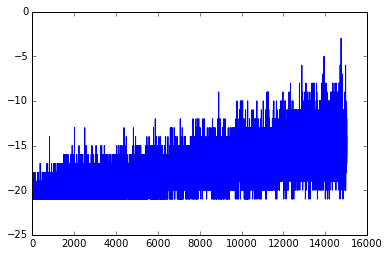

In [9]:
plt.plot(trainer.total_rewards)